<font color="blue">Actividad</font>

* Accede al tablero del CONACyT sobre los contagios por COVID en México: https://datos.covid-19.conacyt.mx/
* Descarga los datos de contagios diarios (panel de la izquierda)
* Construye la serie de tiempo de los casos a nivel nacional.
* Construye la serie de tiempo de los casos en Quintana Roo.

*   Describe las características de las series de tiempo obtenidas.
*   Entregable: Libreta de Colab




## Se importan las bibliotecas necesarias

In [ ]:
pip install skforecast


In [ ]:
pip install pmdarima


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import numpy as np


In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.gofplots import qqplot
import itertools
import statsmodels.api as sm

In [17]:
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import  mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import  mean_absolute_percentage_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [18]:
from pmdarima import auto_arima

# Lectura de Datos


In [31]:
contagioCOVID = pd.read_csv('/content/casosDiariosNacional.csv',encoding = 'unicode_escape')
contagioCOVID.head()

,cve_ent,poblacion,nombre,26-02-2020,27-02-2020,28-02-2020,29-02-2020,01-03-2020,02-03-2020,03-03-2020,...,15-06-2023,16-06-2023,17-06-2023,18-06-2023,19-06-2023,20-06-2023,21-06-2023,22-06-2023,23-06-2023,24-06-2023
0,1,1434635,AGUASCALIENTES,0,0,0,0,0,0,0,...,2,3,0,0,4,3,2,5,0,0
1,2,3634868,BAJA CALIFORNIA,0,0,0,0,0,0,0,...,23,22,0,2,25,27,24,19,6,0
2,3,804708,BAJA CALIFORNIA SUR,0,0,0,0,0,0,0,...,6,3,0,0,5,2,6,2,3,0
3,4,1000617,CAMPECHE,0,0,0,0,0,0,0,...,8,7,0,7,2,3,2,0,7,0
4,7,5730367,CHIAPAS,0,0,0,1,0,0,0,...,6,5,0,0,7,9,8,4,3,0


# Se construye la serie de tiempo de los casos a nivel nacional.


### *Tomando* todas las fechas de manera individual (sin dividir por meses el tiempo)

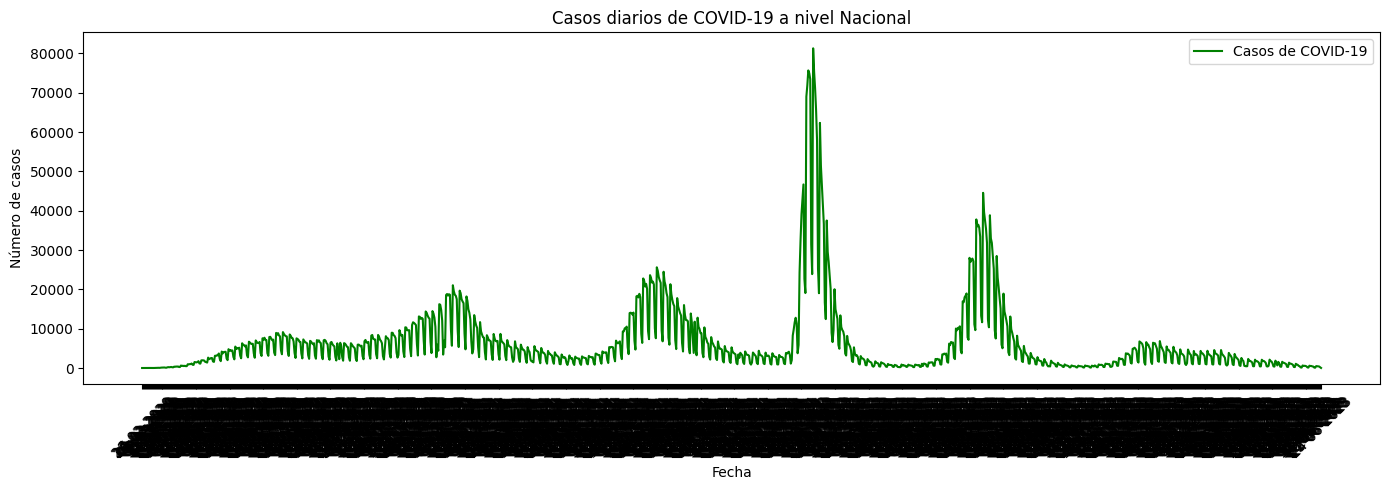

In [44]:
# Filtrando los datos para el registro "Nacional"
datos_nacional = contagioCOVID[contagioCOVID['nombre'] == "Nacional"]
datos_quintanaRoo = contagioCOVID[contagioCOVID['nombre'] == "QUINTANA ROO"]
# Asumiendo que las fechas están en las columnas a partir de la cuarta columna
fechas = datos_nacional.columns[3:]
casos = datos_nacional.iloc[0, 3:]

# Creando el gráfico nuevamente
plt.figure(figsize=(14, 5))
plt.plot(fechas, casos, label='Casos de COVID-19', color='green')
plt.title('Casos diarios de COVID-19 a nivel Nacional')
plt.xlabel('Fecha')
plt.ylabel('Número de casos')
plt.xticks(rotation=45)  # Rotación de las etiquetas del eje x para mejor lectura
plt.tight_layout()
plt.legend()
plt.show()

### Realizando un gráfico con la división temporal en meses

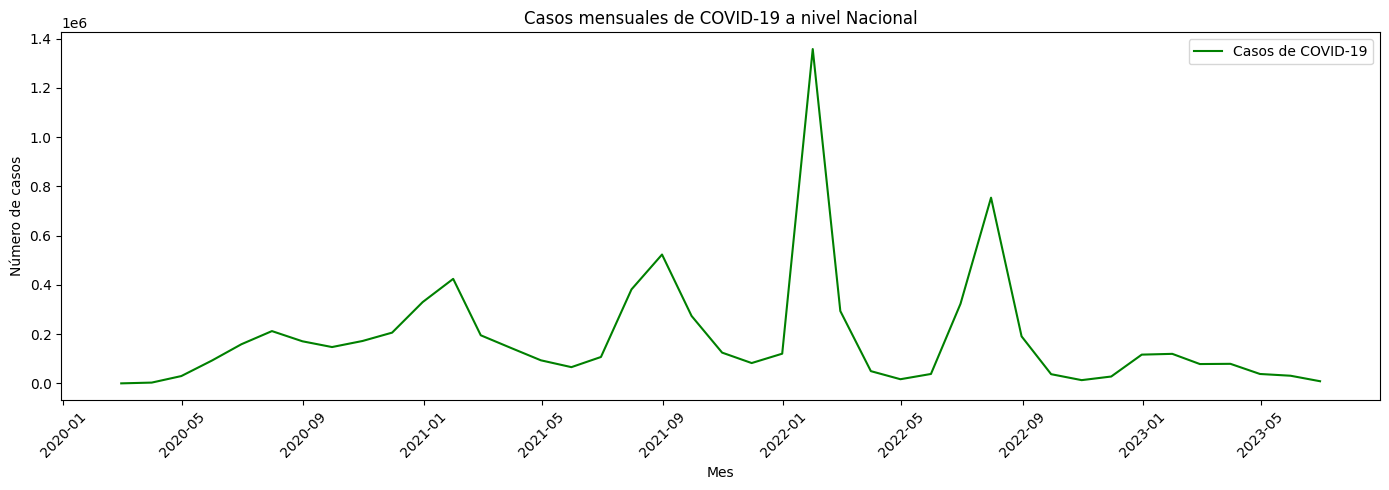

In [45]:
datos_nacional_mensual = datos_nacional.iloc[:, 3:]  # Excluyendo las columnas no temporales
datos_nacional_mensual.columns = pd.to_datetime(datos_nacional_mensual.columns, format='%d-%m-%Y')

# Agrupando por mes y sumando los casos
datos_mensuales = datos_nacional_mensual.T.resample('M').sum()

# Creando el gráfico de los datos mensuales
plt.figure(figsize=(14, 5))
plt.plot(datos_mensuales.index, datos_mensuales.iloc[:, 0], label='Casos de COVID-19', color='green')  # Asumiendo que "Nacional" es la única fila
plt.title('Casos mensuales de COVID-19 a nivel Nacional')
plt.xlabel('Mes')
plt.ylabel('Número de casos')
plt.xticks(rotation=45)  # Rotación de las etiquetas del eje x para mejor lectura
plt.tight_layout()
plt.legend()
plt.show()

# Se construye la serie de tiempo de los casos en Quintana Roo.

### *Tomando* todas las fechas de manera individual (sin dividir por meses el tiempo)

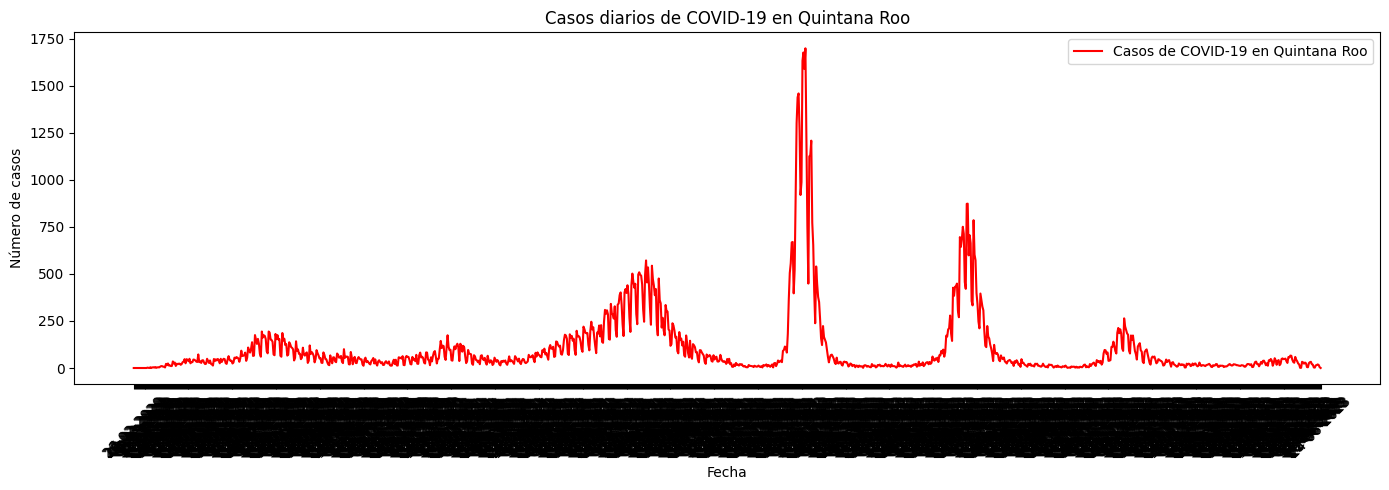

In [46]:
# Filtrando los datos para "Quintana Roo"
datos_quintana_roo = datos_quintanaRoo[datos_quintanaRoo['nombre'] == "QUINTANA ROO"]

# Verificando si hay datos en el DataFrame
if not datos_quintana_roo.empty:
    # Procede con tu código si hay datos
    fechas_quintana_roo = datos_quintana_roo.columns[3:]
    casos_quintana_roo = datos_quintana_roo.iloc[0, 3:]

    # Creando el gráfico
    plt.figure(figsize=(14, 5))
    plt.plot(fechas_quintana_roo, casos_quintana_roo, label='Casos de COVID-19 en Quintana Roo', color='red')
    plt.title('Casos diarios de COVID-19 en Quintana Roo')
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos')
    plt.xticks(rotation=45)  # Rotación de las etiquetas del eje x
    plt.tight_layout()
    plt.legend()
    plt.show()
else:
    print("No hay datos disponibles para 'Quintana Roo'")

### Realizando un gráfico con la división temporal en meses

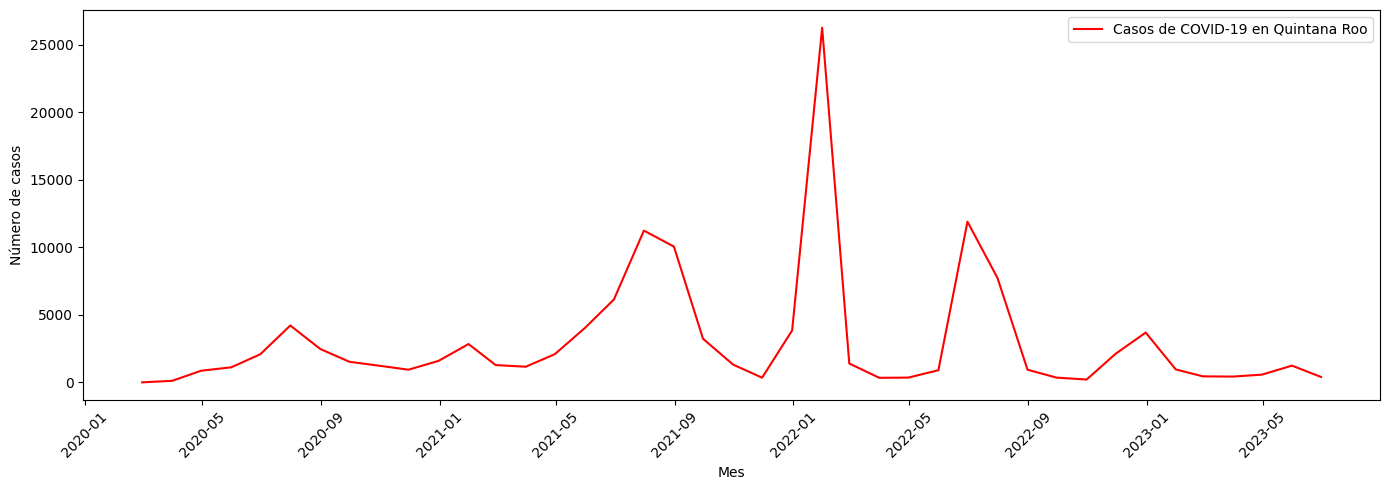

In [48]:
datos_quintana_roo_mensual = datos_quintana_roo.iloc[:, 3:].copy()
datos_quintana_roo_mensual.columns = pd.to_datetime(datos_quintana_roo_mensual.columns, format='%d-%m-%Y')

# Agrupando por mes y sumando los casos
datos_mensuales_quintana_roo = datos_quintana_roo_mensual.T.resample('M').sum()

# Creando el gráfico de los datos mensuales
plt.figure(figsize=(14, 5))
plt.plot(datos_mensuales_quintana_roo.index, datos_mensuales_quintana_roo.iloc[:, 0], label='Casos de COVID-19 en Quintana Roo', color='red')
plt.xlabel('Mes')
plt.ylabel('Número de casos')
plt.xticks(rotation=45)  # Rotación de las etiquetas del eje x para mejor lectura
plt.tight_layout()
plt.legend()
plt.show()

# Describe las características de las series de tiempo obtenidas.

## **Análisis del gráfico de casos de COVID en Quintana Roo**

La serie temporal de casos de COVID-19 en Quintana Roo muestra múltiples picos que sugieren una fuerte estacionalidad, probablemente relacionada con el ciclo turístico de la región. La presencia de estos picos estacionales puede indicar que los incrementos en el número de casos están ligados a temporadas altas de turismo, cuando la interacción entre individuos es más frecuente. La serie no parece ser estacionaria, ya que tanto la media como la varianza varían significativamente a lo largo del tiempo, particularmente en respuesta a estos picos. Además, la serie no muestra homocedasticidad, ya que la dispersión de los casos cambia notablemente durante periodos de altos y bajos casos, reflejando una variabilidad de la dispersión a lo largo del tiempo.



## **Análisis del gráfico de casos de COVID a nivel nacional**

La gráfica de casos de COVID-19 a nivel nacional también revela varios picos, aunque con menos regularidad que en Quintana Roo, lo que podría reflejar una menor influencia de factores estacionales específicos en comparación con un destino turístico. La tendencia general muestra incrementos y disminuciones, pero no una dirección clara a largo plazo, sugiriendo la falta de una tendencia definida. La serie no parece ser estacionaria debido a cambios significativos en la media y la varianza especialmente en torno a los picos. Similar a Quintana Roo, la serie nacional también carece de homocedasticidad, con variaciones en la dispersión asociadas a los periodos de aumento o disminución de casos.

## **Comparación de los 2 gráficos y conclusiones**

Comparando las series de tiempo de Quintana Roo y a nivel nacional, ambas muestran características de no estacionariedad y falta de homocedasticidad, indicativas de la dinámica compleja de la transmisión del COVID-19. Mientras que Quintana Roo muestra una estacionalidad más marcada, probablemente debido a su dependencia del turismo, la serie nacional refleja una mezcla más compleja de factores que podrían incluir diferencias regionales en medidas de salud pública, movilidad de la población y diversidad climática. Ambas series subrayan la importancia de considerar factores locales y nacionales en la respuesta a la pandemia, y cómo estos factores pueden influir en la aparición de casos de COVID-19.